# Assignment 2

Use this notebook to write your code for assignment 2

# Pre-processing data

Read the data file of `shakespeare.txt` and prepare the inputs/outputs to your model.

In [1]:
from collections import defaultdict
import math
import string
import random
import re
import time


import torch
import torch.nn as nn
from torch.autograd import Variable

import unidecode
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline

In [2]:
all_characters = string.printable # list of all possible characters (from string)
num_characters = len(all_characters) # number of possible characters

text = unidecode.unidecode(open('./data/shakespeare.txt').read())
text = re.sub("\d|\n{2,}|\s{2,}","", text)

text_len = len(text) 

sequence_len = 40

def generate_sequence():
    start_index = random.randint(0, text_len - sequence_len)
    end_index = start_index + sequence_len + 1
    return text[start_index:end_index]


# Build the Model

Implement a character-based LSTM model 

In [3]:
class SimplePoet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimplePoet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self): 
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

In [4]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)


# Training

The main training routine

In [5]:
def generate_training_set():    
    sequence = generate_sequence()
    inp = char_tensor(sequence[:-1])
    target = char_tensor(sequence[1:])
    return inp, target

In [6]:

def evaluate_SimplePoet(character_seed='A', predict_len=100, temperature=0.8):
    
    hidden = decoder.init_hidden()
    seed_input = char_tensor(character_seed)
    predicted_string = character_seed

    for p in range(len(character_seed) - 1):
        _, hidden = decoder(seed_input[p], hidden)
    inp = seed_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        output_distribution = output.data.view(-1).div(temperature).exp()
        top_character = torch.multinomial(output_distribution, 1)[0]
        predicted_char = all_characters[top_character]
        predicted_string += predicted_char 
        inp = char_tensor(predicted_char) 
        
    return predicted_string

In [7]:

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()

    loss = 0

    for c in range(sequence_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, torch.LongTensor([target[c]]))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / sequence_len

In [8]:
def runtime(instant):
    seconds = time.time() - instant
    minutes= math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

In [9]:
num_epochs = 3000
print_every = 500 
plot_every = 10 
hidden_size = 200
num_layers = 1
learning_rate = 0.005

decoder = SimplePoet(num_characters, hidden_size, num_characters, num_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = [] 
loss_avg = 0

for epoch in range(1, num_epochs + 1):
    loss = train(*generate_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[Runtime: %s, Epoch: %d (%d%%), Loss: %.4f]' % (runtime(start), epoch, epoch / num_epochs * 100, loss))
        print(evaluate_SimplePoet('As', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every) 
        loss_avg = 0

[Runtime: 0m 19s, Epoch: 500 (16%), Loss: 2.3203]
As you deake wot thin
Who im so womb
Make eforn thou whought ho, ming and thou mings ofn eter he, thou 

[Runtime: 0m 39s, Epoch: 1000 (33%), Loss: 2.1171]
As worth s that pat'st's of thou all to that the seect me.
he all trueched of for dot afllom the ae we 

[Runtime: 0m 58s, Epoch: 1500 (50%), Loss: 1.8395]
As ming,
Which ath scare,
When blatu the worlds wain mine what pose of wome tree sweet or rave mandit  

[Runtime: 1m 18s, Epoch: 2000 (66%), Loss: 1.8565]
Astander me so whereful beress hered for braruth on fintear line make mand fain's thy ringrith be of t 

[Runtime: 1m 38s, Epoch: 2500 (83%), Loss: 1.4288]
As shide,
To love with and of be of love days not mese of me les lone dew the all every like ip they m 

[Runtime: 1m 57s, Epoch: 3000 (100%), Loss: 1.8349]
As my self to some live,
Such poor for plise the ghand of noty to foul fors.
To mory know'st one some  



# Plotting the Training Losses

Plotting the historical loss during training:

Text(0, 0.5, 'Loss')

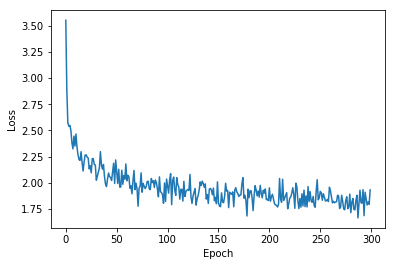

In [10]:
# Plot Loss function using "all_losses"

plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')


# Evaluating at different "temperatures"

Changing the `temperature` argument (variance) for 1.5, 0.75. 0.25 and sample outputs from the trained model.


References:
* [Shakespeare Sonnets](http://shakespeare.mit.edu/Poetry/sonnets.html)

In [11]:
print(evaluate_SimplePoet('As fast as thou shalt wane, so fast thou growest\n', 300, temperature=1.5))

As fast as thou shalt wane, so fast thou growest
Sweawse thy deperfel '`iter that come goacoude,
Mold:And fhed beautint coodi!Buentime enoyst wildllednel,
And nidleshan e!WholdectAmveotly thet,
Yountcy:
Sten,Line
Whiss trantkst,
Rivee vity.
Bow faymectolds' race.y mevermighte,
To-m'sabel;
Solds.
'Gismeft andy wit my onetirmflocivisives I sormen
Et


In [12]:
print(evaluate_SimplePoet('As fast as thou shalt wane, so fast thou growest\n', 300, temperature=0.75))

As fast as thou shalt wane, so fast thou growest
When beiter forming the canss'st swerself my somess any mive with more to lives ford that power doth love they commiten of the thoughts woth so shall sweets youre,
And they comment in live noth in so my reeving mood any brink,
And soment,
Then of of that thy deage they noty eself thee doth child wit


In [13]:
print(evaluate_SimplePoet('As fast as thou shalt wane, so fast thou growest\n', 300, temperature=0.25))

As fast as thou shalt wane, so fast thou growest
And former thee dear the forments and thee of the sing,
And shall of the dear self thee of the self thee and the sweet thee self the so should of that the shall the see of the so shall and beauty some dear and thee the can the so shall the the have of they self comments the so shall thy so of the se


# Improving the Model (SimplePoet)

1. Concatenating words and characters. (Section 4.1 Language Model)

References:

* [Deep-speare](http://aclweb.org/anthology/P18-1181)

## Concatenating words and characters

In [14]:
def process_words():
    words = []
    dline = defaultdict(list)
    avg_line = 0
    total = 0
    for line in text.splitlines():
        if len(line) > 0:
            wordup = line.split()
            words.extend(wordup)
            avg_line += len(wordup)
            total += 1
            dline[wordup[0]].append(line)
        
    avg_line = round(avg_line / total)
    unique_words = list(set(words))
    unique_words.sort()
    return unique_words, dline, avg_line
    

In [15]:
def word_tensor(sentence: list):
    tensor = torch.zeros(len(sentence)).long()
    for c in range(len(sentence)):
        tensor[c] = unique_words.index(sentence[c])
    return Variable(tensor)
    

In [16]:
def generate_word_sequence():
    
    start_index = random.randint(0, len(dlist) -1)
    items = dline[dlist[start_index]]
    choose_item = random.randint(0, len(items)-1)
    candidates = items[choose_item].split()
    
    return candidates
    

In [17]:
def generate_words_training_set():    
    sequence = generate_word_sequence()
    inp = word_tensor(sequence[:-1])
    target = word_tensor(sequence[1:])
    return inp, target

In [18]:
def generate_words_chars_training_set():
    i_0, t_0 = generate_training_set()
    i_1, t_1 = generate_words_training_set()
    inp = torch.cat((i_0, i_1),0)
    target = torch.cat((t_0, t_1),0)
    return inp, target

In [19]:
# Generate word info

unique_words, dline, avg_line = process_words()
dlist = list(dline.keys())


In [20]:
# Train the updated SimplePoet model

num_epochs = 3000
print_every = 500 
plot_every = 10 
hidden_size = 200
num_layers = 1
learning_rate = 0.005
num_items = num_characters + len(unique_words)

decoder = SimplePoet(num_items, hidden_size, num_items, num_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = [] 
loss_avg = 0

for epoch in range(1, num_epochs + 1):
    loss = train(*generate_words_chars_training_set())      
    loss_avg += loss

    if epoch % print_every == 0:
        print('[Runtime: %s, Epoch: %d (%d%%), Loss: %.4f]' % (runtime(start), epoch, epoch / num_epochs * 100, loss))
        print(evaluate_SimplePoet('As', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every) 
        loss_avg = 0

[Runtime: 1m 16s, Epoch: 500 (16%), Loss: 2.1080]
Ast berall meany wier onse fore thy my beour tl'st mou thy thy pall belt way my no mulls loves preact  

[Runtime: 2m 33s, Epoch: 1000 (33%), Loss: 2.2635]
As dtes hteare, this some seles androtho hise prow sort welf thee se my bende thyst ar to self seve,
T 

[Runtime: 4m 8s, Epoch: 1500 (50%), Loss: 1.9540]
As thee thee,
And thee borad band envis being so for sasst sore uppill thou stor struly wore thy thee  

[Runtime: 5m 45s, Epoch: 2000 (66%), Loss: 1.9118]
As thou shamow but shat then ack my lave fite,
So be pit that that sweely soult the the but that the l 

[Runtime: 7m 20s, Epoch: 2500 (83%), Loss: 1.8532]
As a she warts,
And but what the hath doast love, deauty my doost,
Unuded, my mune,
And alt thy mak, t 

[Runtime: 8m 56s, Epoch: 3000 (100%), Loss: 1.8045]
As ow and swee I not on und the what our this of yettien's nows than my ming thou love this pay hou ey 



Text(0, 0.5, 'Loss')

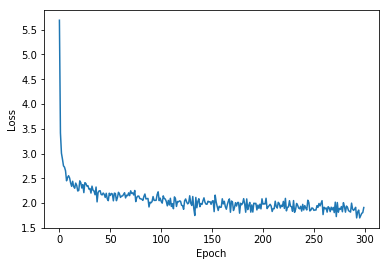

In [21]:
plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [22]:
print(evaluate_SimplePoet('As fast as thou shalt wane, so fast thou growest\n', 300, temperature=0.75))

As fast as thou shalt wane, so fast thou growest
When wore must not pare,
And mine am my joy me that my con thust chill, on that that had my thing tan a hich then the purty I acque,
The nure's hich all that the the silf my sweet most true me be this may I not they ming in in thou dear the wage ou sure stees,
For a chay ming sund
nd mour not thich 
